In [1]:
# Import packages
import sys, os, warnings
import numpy as np
import pandas as pd
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Ignore warning
warnings.filterwarnings('ignore')

## Preprocessing

In [2]:
# Read the data from the test set and the training set
train = pd.read_csv('/kaggle/input/dataset/train.csv')
test = pd.read_csv('/kaggle/input/dataset/test.csv')

In [3]:
# Process the missing values in tables
missing_values = train.isnull().sum()
print(missing_values)

EmployeeID                  0
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
Shift                       0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [4]:
# Remove useless attributes from the table so that they do not affect the final prediction results
processed_train_data = train.drop(['EmployeeCount', 'EmployeeID', 'Over18', 'StandardHours'], axis=1).copy()
processed_test_data = test.drop(['EmployeeCount', 'EmployeeID', 'Over18', 'StandardHours'], axis=1).copy()

processed_train_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,35,No,Non-Travel,1225,Maternity,2,4,Life Sciences,4,Female,...,3,1,1,16,2,4,1,0,0,0
1,37,No,Travel_Rarely,674,Maternity,13,3,Medical,1,Male,...,3,1,0,10,2,3,10,8,3,7
2,49,No,Travel_Frequently,1475,Maternity,28,2,Life Sciences,1,Male,...,4,1,0,20,2,3,4,3,1,3
3,50,No,Travel_Rarely,1207,Maternity,28,1,Medical,4,Male,...,3,3,3,20,3,3,20,8,3,8
4,50,No,Travel_Rarely,939,Maternity,24,3,Life Sciences,4,Male,...,3,4,1,22,2,3,12,11,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,30,No,Travel_Rarely,911,Neurology,1,2,Medical,4,Male,...,3,3,0,12,6,2,12,8,1,7
1253,28,Yes,Travel_Frequently,773,Maternity,6,3,Life Sciences,3,Male,...,3,4,1,3,2,3,3,1,0,2
1254,26,No,Travel_Rarely,583,Maternity,4,2,Life Sciences,3,Male,...,4,2,0,8,2,2,8,5,2,2
1255,25,Yes,Travel_Rarely,383,Cardiology,9,2,Life Sciences,1,Male,...,3,1,0,6,2,3,3,2,2,2


In [5]:
# Distinguish between text-type attributes and numeric-type attributes in a table so that they can be subsequently processed separately
column_with_text = [column for column in processed_train_data.columns if processed_train_data.dtypes[column] == 'object']
column_with_number = [column for column in processed_train_data.columns if processed_train_data.dtypes[column] !='object']

print(column_with_text)
print(column_with_number)

['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'Shift', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [6]:
# Convert continuous data in the training set to discrete data using the kBinsDiscretizer technique
processed_train_data_new = processed_train_data.copy()
for column in column_with_number:
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    discretizer.fit(processed_train_data[[column]])
    processed_train_data_new[column] = discretizer.transform(processed_train_data[[column]]).ravel()

processed_train_data = processed_train_data_new
processed_train_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,4.0,No,Non-Travel,8.0,Maternity,0.0,7.0,Life Sciences,9.0,Female,...,0.0,0.0,3.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0
1,4.0,No,Travel_Rarely,4.0,Maternity,4.0,5.0,Medical,0.0,Male,...,0.0,0.0,0.0,2.0,3.0,6.0,2.0,4.0,2.0,4.0
2,7.0,No,Travel_Frequently,9.0,Maternity,9.0,2.0,Life Sciences,0.0,Male,...,9.0,0.0,0.0,5.0,3.0,6.0,1.0,1.0,0.0,1.0
3,7.0,No,Travel_Rarely,7.0,Maternity,9.0,0.0,Medical,9.0,Male,...,0.0,6.0,9.0,5.0,5.0,6.0,5.0,4.0,2.0,4.0
4,7.0,No,Travel_Rarely,5.0,Maternity,8.0,5.0,Life Sciences,9.0,Male,...,0.0,9.0,3.0,5.0,3.0,6.0,3.0,6.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2.0,No,Travel_Rarely,5.0,Neurology,0.0,2.0,Medical,9.0,Male,...,0.0,6.0,0.0,3.0,9.0,3.0,3.0,4.0,0.0,4.0
1253,2.0,Yes,Travel_Frequently,4.0,Maternity,1.0,5.0,Life Sciences,6.0,Male,...,0.0,9.0,3.0,0.0,3.0,6.0,0.0,0.0,0.0,1.0
1254,1.0,No,Travel_Rarely,3.0,Maternity,1.0,2.0,Life Sciences,6.0,Male,...,9.0,3.0,0.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0
1255,1.0,Yes,Travel_Rarely,2.0,Cardiology,2.0,2.0,Life Sciences,0.0,Male,...,0.0,0.0,0.0,1.0,3.0,6.0,0.0,1.0,1.0,1.0


In [7]:
# Conversion of continuous data in the test set to discrete data using kBinsDiscretizer technology
processed_test_data_new = processed_test_data.copy()
for column in column_with_number:
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    discretizer.fit(processed_test_data[[column]])
    processed_test_data_new[column] = discretizer.transform(processed_test_data[[column]]).ravel()

processed_test_data = processed_test_data_new
processed_test_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,5.0,NaN,Travel_Rarely,7.0,Cardiology,0.0,2.0,Life Sciences,3.0,Female,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,2.0
1,4.0,NaN,Travel_Rarely,9.0,Maternity,0.0,2.0,Other,9.0,Male,...,0.0,3.0,0.0,1.0,5.0,6.0,0.0,0.0,0.0,0.0
2,2.0,NaN,Travel_Rarely,0.0,Maternity,5.0,2.0,Life Sciences,9.0,Female,...,0.0,9.0,0.0,2.0,5.0,6.0,2.0,2.0,0.0,4.0
3,3.0,NaN,Travel_Rarely,8.0,Maternity,6.0,2.0,Medical,3.0,Male,...,0.0,6.0,3.0,0.0,3.0,6.0,0.0,1.0,0.0,1.0
4,0.0,NaN,Non-Travel,7.0,Maternity,5.0,2.0,Medical,9.0,Male,...,0.0,3.0,6.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.0,NaN,Travel_Rarely,3.0,Cardiology,4.0,0.0,Medical,3.0,Male,...,0.0,6.0,0.0,1.0,1.0,6.0,1.0,2.0,0.0,3.0
415,1.0,NaN,Travel_Frequently,3.0,Cardiology,8.0,5.0,Medical,9.0,Male,...,0.0,6.0,6.0,0.0,5.0,6.0,0.0,1.0,1.0,0.0
416,2.0,NaN,Travel_Rarely,1.0,Neurology,1.0,0.0,Medical,9.0,Male,...,0.0,9.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0
417,4.0,NaN,Travel_Rarely,0.0,Neurology,7.0,5.0,Life Sciences,9.0,Male,...,0.0,6.0,0.0,1.0,3.0,6.0,1.0,2.0,2.0,1.0


In [8]:
# Encode columns of text attributes with LabelEncoder
label_encoder = LabelEncoder()

# Coding the training set
for column in column_with_text:
    processed_train_data[column] = label_encoder.fit_transform(processed_train_data[column])

# Coding the test set
for column in column_with_text:
    processed_test_data[column] = label_encoder.fit_transform(processed_test_data[column])

processed_train_data
processed_test_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,5.0,0,2,7.0,0,0.0,2.0,1,3.0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,2.0
1,4.0,0,2,9.0,1,0.0,2.0,4,9.0,1,...,0.0,3.0,0.0,1.0,5.0,6.0,0.0,0.0,0.0,0.0
2,2.0,0,2,0.0,1,5.0,2.0,1,9.0,0,...,0.0,9.0,0.0,2.0,5.0,6.0,2.0,2.0,0.0,4.0
3,3.0,0,2,8.0,1,6.0,2.0,3,3.0,1,...,0.0,6.0,3.0,0.0,3.0,6.0,0.0,1.0,0.0,1.0
4,0.0,0,0,7.0,1,5.0,2.0,3,9.0,1,...,0.0,3.0,6.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1.0,0,2,3.0,0,4.0,0.0,3,3.0,1,...,0.0,6.0,0.0,1.0,1.0,6.0,1.0,2.0,0.0,3.0
415,1.0,0,1,3.0,0,8.0,5.0,3,9.0,1,...,0.0,6.0,6.0,0.0,5.0,6.0,0.0,1.0,1.0,0.0
416,2.0,0,2,1.0,2,1.0,0.0,3,9.0,1,...,0.0,9.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0
417,4.0,0,2,0.0,2,7.0,5.0,1,9.0,1,...,0.0,6.0,0.0,1.0,3.0,6.0,1.0,2.0,2.0,1.0


In [9]:
# Use MinMaxScaler tool to nomarlize all the data
from sklearn.preprocessing import MinMaxScaler as MM

normalized_train_data = processed_train_data
normalized_test_data = processed_test_data
list_to_normalize = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 
                     'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
                     'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
                     'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'Shift', 'TotalWorkingYears', 
                     'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                     'YearsSinceLastPromotion', 'YearsWithCurrManager']

# Do the MinMaxScaler operation on the training set
for column in list_to_normalize:
    normalized_train_data_value = normalized_train_data[column].values
    reshaped = normalized_train_data_value.reshape(-1,1)
    processed_train_data['{}_normalized'.format(column)] = MM().fit_transform(reshaped)

normalized_train_data = processed_train_data.drop(list_to_normalize, axis='columns')

# Do the MinMaxScaler operation on the testing set
for column in list_to_normalize:
    normalized_test_data_value = normalized_test_data[column].values
    reshaped = normalized_test_data_value.reshape(-1,1)
    normalized_test_data['{}_normalized'.format(column)] = MM().fit_transform(reshaped)

normalized_test_data = normalized_test_data.drop(list_to_normalize, axis='columns')

normalized_train_data

,Attrition,BusinessTravel_normalized,Department_normalized,EducationField_normalized,Gender_normalized,JobRole_normalized,MaritalStatus_normalized,OverTime_normalized,Age_normalized,DailyRate_normalized,...,PerformanceRating_normalized,RelationshipSatisfaction_normalized,Shift_normalized,TotalWorkingYears_normalized,TrainingTimesLastYear_normalized,WorkLifeBalance_normalized,YearsAtCompany_normalized,YearsInCurrentRole_normalized,YearsSinceLastPromotion_normalized,YearsWithCurrManager_normalized
0,0,0.0,0.5,0.2,0.0,0.50,0.0,0.0,0.444444,0.888889,...,0.0,0.000000,0.333333,0.444444,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000
1,0,1.0,0.5,0.6,1.0,0.50,0.5,0.0,0.444444,0.444444,...,0.0,0.000000,0.000000,0.222222,0.333333,0.666667,0.222222,0.444444,0.222222,0.444444
2,0,0.5,0.5,0.2,1.0,0.50,1.0,0.0,0.777778,1.000000,...,1.0,0.000000,0.000000,0.555556,0.333333,0.666667,0.111111,0.111111,0.000000,0.111111
3,0,1.0,0.5,0.6,1.0,0.50,0.5,1.0,0.777778,0.777778,...,0.0,0.666667,1.000000,0.555556,0.555556,0.666667,0.555556,0.444444,0.222222,0.444444
4,0,1.0,0.5,0.2,1.0,1.00,0.5,1.0,0.777778,0.555556,...,0.0,1.000000,0.333333,0.555556,0.333333,0.666667,0.333333,0.666667,0.000000,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0,1.0,1.0,0.6,1.0,0.50,0.5,0.0,0.222222,0.555556,...,0.0,0.666667,0.000000,0.333333,1.000000,0.333333,0.333333,0.444444,0.000000,0.444444
1253,1,0.5,0.5,0.2,1.0,0.50,0.0,1.0,0.222222,0.444444,...,0.0,1.000000,0.333333,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.111111
1254,0,1.0,0.5,0.2,1.0,0.50,1.0,1.0,0.111111,0.333333,...,1.0,0.333333,0.000000,0.222222,0.333333,0.333333,0.222222,0.222222,0.111111,0.111111
1255,1,1.0,0.0,0.2,1.0,0.75,0.5,0.0,0.111111,0.222222,...,0.0,0.000000,0.000000,0.111111,0.333333,0.666667,0.000000,0.111111,0.111111,0.111111


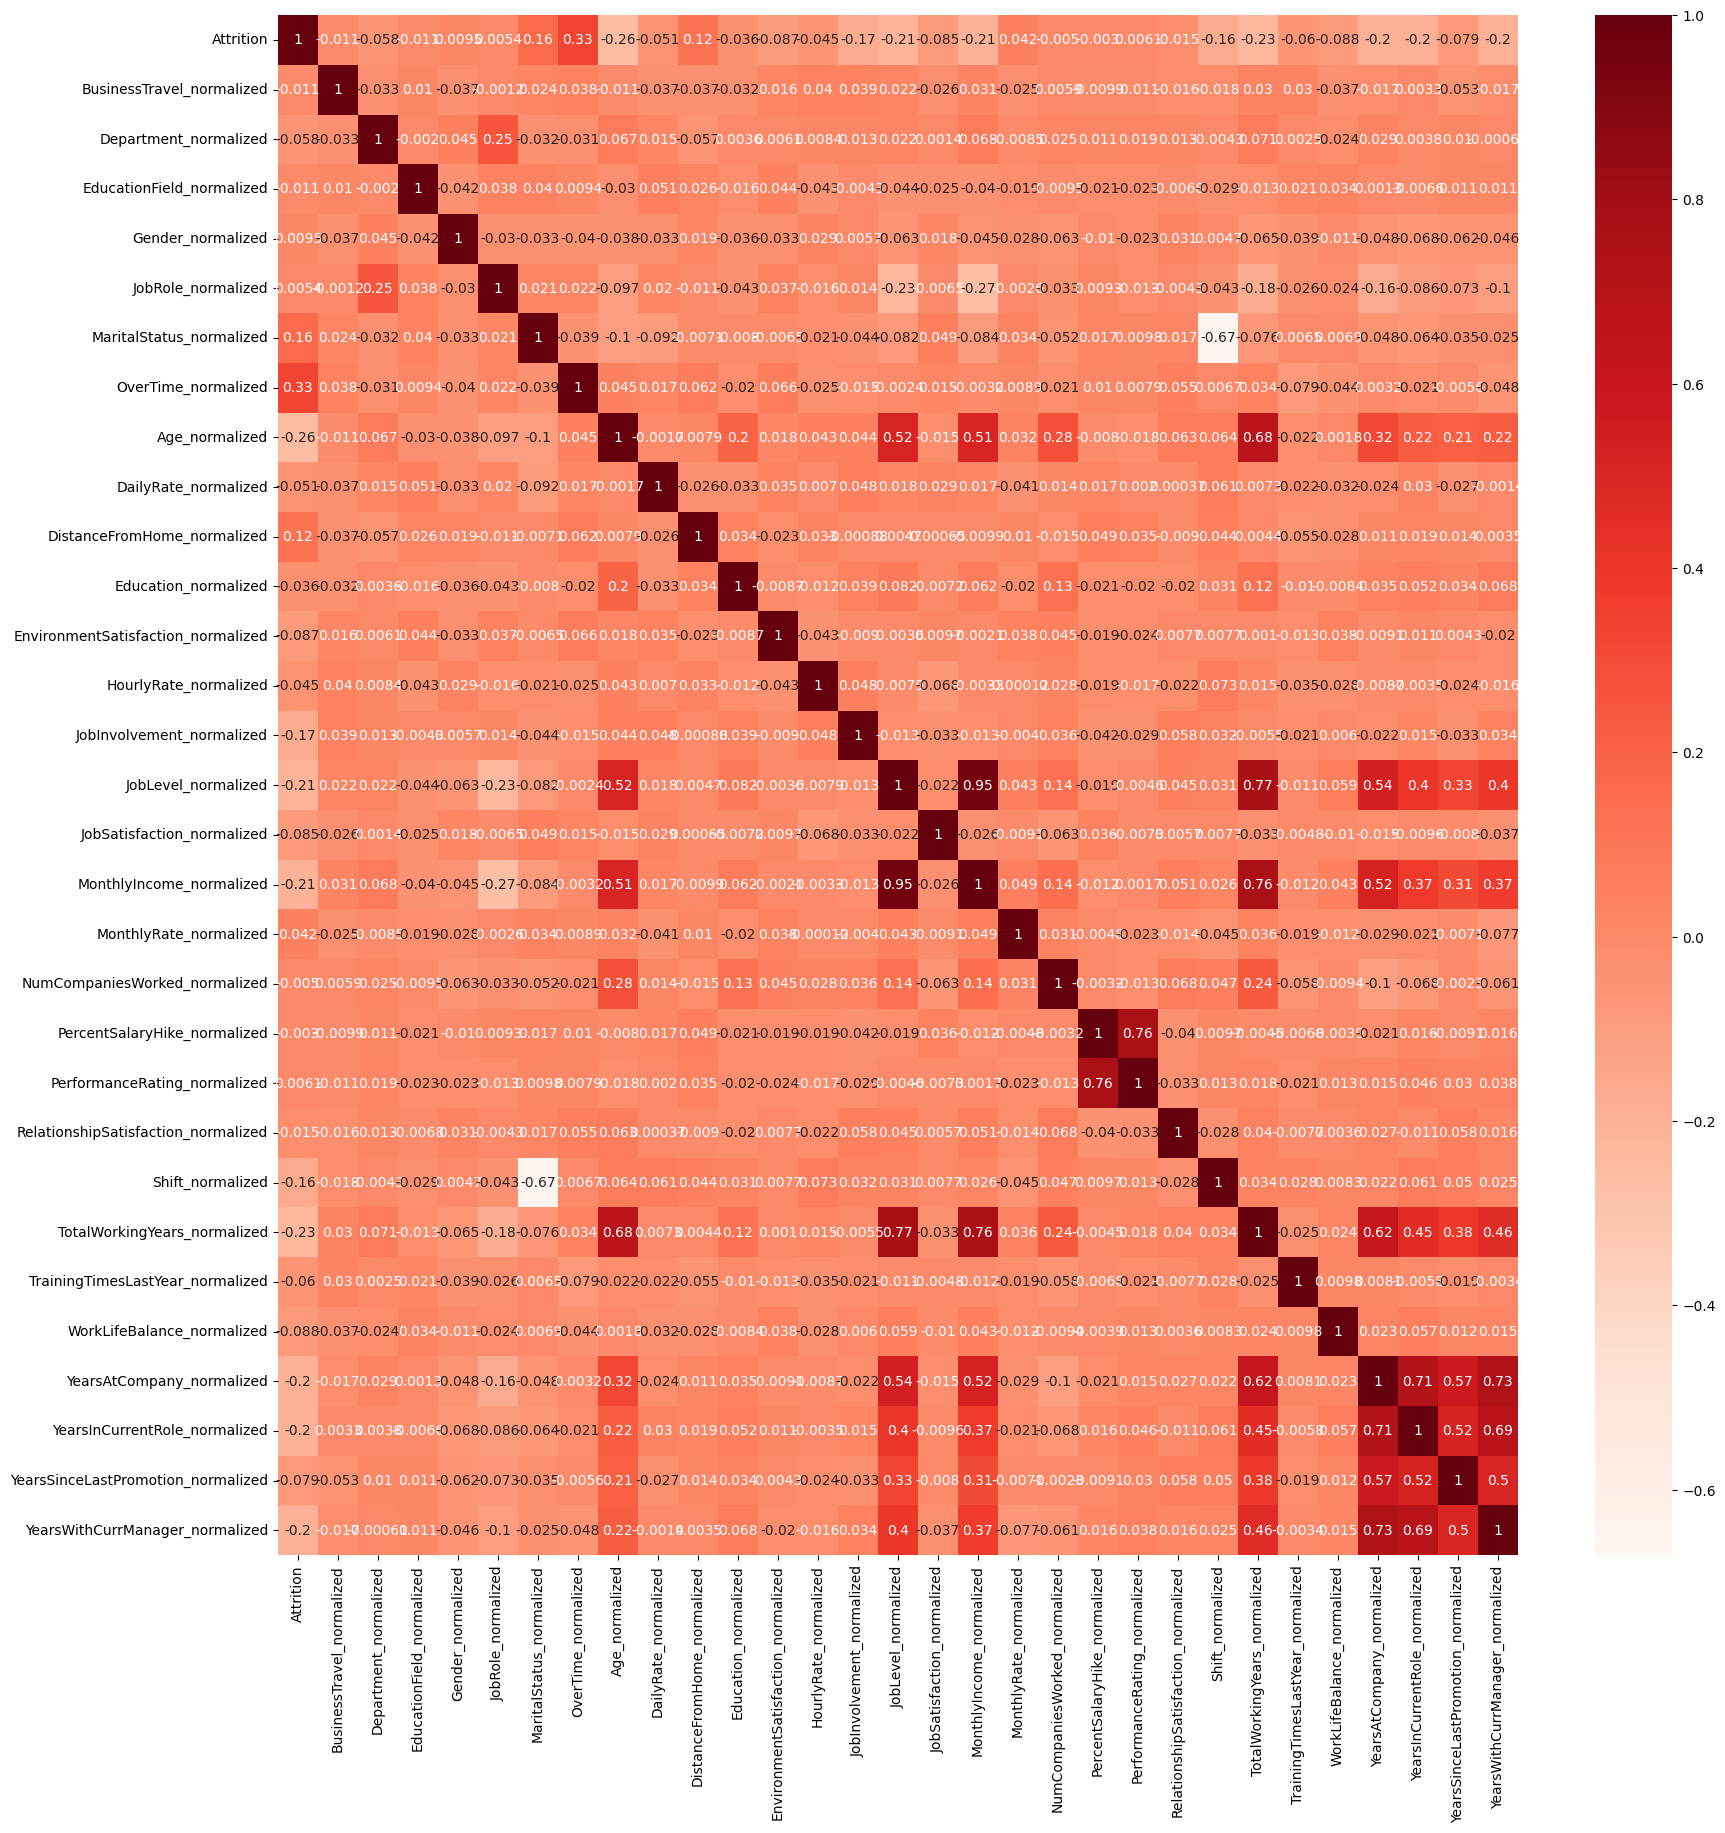

Top 15 features most correlated with 'Attrition':
OverTime_normalized                   0.328223
Age_normalized                        0.258593
TotalWorkingYears_normalized          0.233699
JobLevel_normalized                   0.211461
MonthlyIncome_normalized              0.206148
YearsInCurrentRole_normalized         0.199757
YearsAtCompany_normalized             0.198854
YearsWithCurrManager_normalized       0.198480
JobInvolvement_normalized             0.172662
MaritalStatus_normalized              0.164145
Shift_normalized                      0.162378
DistanceFromHome_normalized           0.118715
WorkLifeBalance_normalized            0.087940
EnvironmentSatisfaction_normalized    0.087392
JobSatisfaction_normalized            0.084684
Name: Attrition, dtype: float64
['OverTime_normalized', 'Age_normalized', 'TotalWorkingYears_normalized', 'JobLevel_normalized', 'MonthlyIncome_normalized', 'YearsInCurrentRole_normalized', 'YearsAtCompany_normalized', 'YearsWithCurrManager_norm

In [10]:
# Use Pearson Correlation to find the attributes that are highly correlated with ‘Attrition’
plt.figure(figsize=(20, 20))
cor = normalized_train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Select the top 15 attributes with the highest correlation coefficient with 'Attrition'
cor_target = abs(cor['Attrition'])
relevant_features = cor_target.sort_values(ascending=False)[1:16]
print("Top 15 features most correlated with 'Attrition':")
print(relevant_features)

relevant_features_list = relevant_features.index.tolist()
print(relevant_features_list)

In [11]:
# New training data after screening 15 attribute values
normalized_train_data_new = pd.concat([normalized_train_data['Attrition'], normalized_train_data[relevant_features_list]], axis=1)

# New test data after screening 15 attribute values
normalized_test_data_new = pd.concat([normalized_test_data['Attrition'], normalized_test_data[relevant_features_list]], axis=1)

normalized_train_data_new

,Attrition,OverTime_normalized,Age_normalized,TotalWorkingYears_normalized,JobLevel_normalized,MonthlyIncome_normalized,YearsInCurrentRole_normalized,YearsAtCompany_normalized,YearsWithCurrManager_normalized,JobInvolvement_normalized,MaritalStatus_normalized,Shift_normalized,DistanceFromHome_normalized,WorkLifeBalance_normalized,EnvironmentSatisfaction_normalized,JobSatisfaction_normalized
0,0,0.0,0.444444,0.444444,0.222222,0.222222,0.000000,0.000000,0.000000,0.666667,0.0,0.333333,0.000000,1.000000,1.000000,0.000000
1,0,0.0,0.444444,0.222222,0.222222,0.111111,0.444444,0.222222,0.444444,0.666667,0.5,0.000000,0.444444,0.666667,0.000000,1.000000
2,0,0.0,0.777778,0.555556,0.222222,0.111111,0.111111,0.111111,0.111111,0.333333,1.0,0.000000,1.000000,0.666667,0.000000,0.000000
3,0,1.0,0.777778,0.555556,0.000000,0.111111,0.444444,0.555556,0.444444,1.000000,0.5,1.000000,1.000000,0.666667,1.000000,0.666667
4,0,1.0,0.777778,0.555556,0.777778,0.666667,0.666667,0.333333,0.222222,0.666667,0.5,0.333333,0.888889,0.666667,1.000000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0,0.0,0.222222,0.333333,0.000000,0.111111,0.444444,0.333333,0.444444,0.666667,0.5,0.000000,0.000000,0.333333,1.000000,0.333333
1253,1,1.0,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.333333,0.0,0.333333,0.111111,0.666667,0.666667,0.666667
1254,0,1.0,0.111111,0.222222,0.000000,0.000000,0.222222,0.222222,0.111111,0.666667,1.0,0.000000,0.111111,0.333333,0.666667,1.000000
1255,1,0.0,0.111111,0.111111,0.000000,0.111111,0.111111,0.000000,0.111111,0.333333,0.5,0.000000,0.222222,0.666667,0.000000,0.000000


In [12]:
# Processing the final form
final_train = normalized_train_data_new
final_test = normalized_test_data_new

In [13]:
# Final conversion to csv file format
final_train.to_csv('final_train2.csv', index=0)
final_test.to_csv('final_test2.csv', index=0)

## Modeling

#### 1. Support Vector Machine (SVM)

In [14]:
# Extract the training values and corresponding labelled values from the dataset and store them in x and y respectively
column_of_nonattrition = final_train.columns != 'Attrition'
column_of_attrition = final_train.columns == 'Attrition'
X = final_train.iloc[:, column_of_nonattrition]
y = final_train.iloc[:, column_of_attrition]

# Use of SMOTE sampling techniques to compensate for uneven distribution of different classes
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_smote, y_smote = sm.fit_resample(X, y)

# Divide the dataset into training and validation data
X_train, X_validate, y_train, y_validate = train_test_split(X_smote, y_smote, test_size=0.2)

# Parameters for model mesh search
params_grid_svm = {   
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Instantiate the RandomForest model and the GridSearchCV method
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, params_grid_svm, scoring="accuracy", cv=5)

# Fit the model using the training data
svm_cv.fit(X_train, y_train.values.ravel())

# Get the best parameters and print them
best_params_svm = svm_cv.best_params_
print(f"Best parameters for SVM: {best_params_svm}")

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [15]:
# Predict the results of the test set and validation set separately
y_validate_pre_svm = svm_cv.predict(X_validate)

print('SVM:')
print('Validating set accuracy score: {:.3f}'.format(accuracy_score(y_validate, y_validate_pre_svm)))
print('Validating set precision score: {:.3f}'.format(precision_score(y_validate, y_validate_pre_svm)))
print('Validating set recall score: {:.3f}'.format(recall_score(y_validate, y_validate_pre_svm)))
print('Validating set f1 score: {:.3f}'.format(f1_score(y_validate, y_validate_pre_svm)))

SVM:
Validating set accuracy score: 0.949
Validating set precision score: 0.902
Validating set recall score: 0.929
Validating set f1 score: 0.915


In [16]:
# Predict the results on a real test set and export the file in csv format
final_test_data = final_test.drop(['Attrition'], axis=1)
result = svm_cv.predict(final_test_data)
result_data = []
for i in range(len(result)):
    if result[i] == 1:
        result_data.append('Yes')
    else:
        result_data.append('No')

EmployeeID = test['EmployeeID']
submission_df = pd.DataFrame({'EmployeeID':EmployeeID, 'Attrition':result_data})
submission_df.to_csv('/kaggle/working/submission.csv', index=0)

SVM's best result on Kaggle is: 0.960

#### 2. eXtreme Gradient Boosting (XGB)

In [17]:
# Define the parameter grid for GridSearchCV
params_grid_xgb = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5, 10, 15],
    'min_child_weight': [None, 1, 5],
    'subsample': [0.5, 1.0, 1.5],
    'colsample_bytree': [0.5, 1.0, 1.5]
}

# Instantiate the model and perform GridSearchCV
xgb_clf = xgb.XGBClassifier()
xgb_cv = GridSearchCV(xgb_clf, params_grid_xgb, scoring='accuracy', cv=5)

# Fit the model on the original data
xgb_cv.fit(X_train, y_train.values.ravel())

# Get the best parameters and print them
best_params_xgb = xgb_cv.best_params_
print(f"Best parameters for XGBoost: {best_params_xgb}")

Best parameters for XGBoost: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.5}


In [18]:
# Predict the results of the test set and validation set separately
y_validate_pre_xgb = xgb_cv.predict(X_validate)

print('XGB:')
print('Validating set accuracy score: {:.3f}'.format(accuracy_score(y_validate, y_validate_pre_xgb)))
print('Validating set precision score: {:.3f}'.format(precision_score(y_validate, y_validate_pre_xgb)))
print('Validating set recall score: {:.3f}'.format(recall_score(y_validate, y_validate_pre_xgb)))
print('Validating set f1 score: {:.3f}'.format(f1_score(y_validate, y_validate_pre_xgb)))

XGB:
Validating set accuracy score: 0.952
Validating set precision score: 0.956
Validating set recall score: 0.879
Validating set f1 score: 0.916


XGB's best result on Kaggle is: 0.952

#### 3. Random Forest (RF)

In [19]:
# Parameters for model mesh search
params_grid_rf = {
    'n_estimators': [10, 50, 100, 200, 400, 500],
    'max_features': ['log2', 'sqrt'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'max_depth': [None, 10, 20, 30, 40]
}

# Instantiate the RandomForest model and the GridSearchCV method
rf_clf = RandomForestClassifier()
rf_cv = GridSearchCV(rf_clf, params_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model using the training data
rf_cv.fit(X_train, y_train.values.ravel())

# Get the best parameters and print them
best_params_rf = rf_cv.best_params_
print(f"Best parameters: {best_params_rf}")

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
# Predict the results of the test set and validation set separately
y_validate_pre_rf = rf_cv.predict(X_validate)

print('RF:')
print('Validating set accuracy score: {:.3f}'.format(accuracy_score(y_validate, y_validate_pre_rf)))
print('Validating set precision score: {:.3f}'.format(precision_score(y_validate, y_validate_pre_rf)))
print('Validating set recall score: {:.3f}'.format(recall_score(y_validate, y_validate_pre_rf)))
print('Validating set f1 score: {:.3f}'.format(f1_score(y_validate, y_validate_pre_rf)))

RF:
Validating set accuracy score: 0.934
Validating set precision score: 0.923
Validating set recall score: 0.848
Validating set f1 score: 0.884


RF's best result on Kaggle is: 0.944